# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [4]:
len(train_doc)

663

In [5]:
len(val_doc)

100

## Preprocessing

In [6]:
def normalize_image1(data):
    return data/127.5-1

def normalize_image2(data):
    return data/255

def normalize_image3(x):
    return (x - x.min()) / (x.max() - x.min())

# Helper function to generate a random affine transform on the iamge
def get_random_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return M

def add_gaussian_noise(image):
    row,col,ch= image.shape
    mean = 0
    #var = 0.1
    #sigma = var**0.5
    gauss = np.random.normal(mean,1,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size, isValidation=False):
    
    x = 30 # number of frames
    y = 120 # image width
    z = 120 # image height
    
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            # We will also build a agumented batch data
            batch_data_aug = np.zeros((batch_size,x,y,z,3))
            batch_labels_aug = np.zeros((batch_size,5))
            
            #Horizontal flip
            batch_data_flip = np.zeros((batch_size,x,y,z,3))
            batch_labels_flip = np.zeros((batch_size,5))
            
            #Gaussian noise
            batch_data_noise = np.zeros((batch_size,x,y,z,3))
            batch_labels_noise = np.zeros((batch_size,5))
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                M = get_random_affine()
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    # Cropping non symmetric frames
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,20:140]
                    
                    resized = cv2.resize(image, (y,z), interpolation = cv2.INTER_AREA)
                    normalized = normalize_image3(resized)
                    batch_data[folder,idx] = normalized
                    
                    #Affine transformation
                    batch_data_aug[folder,idx] = cv2.warpAffine(normalized, M, (normalized.shape[0], normalized.shape[1]))
                    
                    # Data with horizontal flip
                    batch_data_flip[folder,idx]= np.flip(resized,1)
                    
                    #Add gaussian noise
                    batch_data_noise[folder,idx]=add_gaussian_noise(resized)
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                batch_labels_aug[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                batch_labels_noise[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    
                # Labeling data with horizobtal flip, right swipe becomes left swipe and viceversa
                if int(t[folder + (batch*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
                elif int(t[folder + (batch*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                    
                else:
                    batch_labels_flip[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    
            
            batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
            batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)
            batch_data_final = np.append(batch_data_final, batch_data_noise, axis = 0)
            
            batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0)
            batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
            batch_labels_final = np.append(batch_labels_final, batch_labels_noise, axis = 0)
            
            if isValidation:
                batch_data_final=batch_data
                batch_labels_final= batch_labels

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            #Agumented data
            batch_data_aug = np.zeros((batch_size,x,y,z,3))
            batch_labels_aug = np.zeros((batch_size,5))
            
            #Horizontal flip
            batch_data_flip = np.zeros((batch_size,x,y,z,3))
            batch_labels_flip = np.zeros((batch_size,5))
            
            #Gaussian noise
            batch_data_noise = np.zeros((batch_size,x,y,z,3))
            batch_labels_noise = np.zeros((batch_size,5))
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resized = cv2.resize(image, (y,z), interpolation = cv2.INTER_AREA)
                    normalized = normalize_image3(resized)
                    batch_data[folder,idx] = normalized
                    
                    #Affine transformation
                    batch_data_aug[folder,idx] = cv2.warpAffine(normalized, M, (normalized.shape[0], normalized.shape[1]))
                    
                    # Data with horizontal flip
                    batch_data_flip[folder,idx]= np.flip(resized,1)
                    
                    #Add gaussian noise
                    batch_data_noise[folder,idx]=add_gaussian_noise(resized)
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    batch_labels_aug[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    batch_labels_noise[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    
                    # Labeling data with horizobtal flip, right swipe becomes left swipe and viceversa
                    if int(t[folder + (batch*batch_size)].strip().split(';')[2])==0:
                        batch_labels_flip[folder, 1] = 1
                    elif int(t[folder + (batch*batch_size)].strip().split(';')[2])==1:
                        batch_labels_flip[folder, 0] = 1
                    
                    else:
                        batch_labels_flip[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    
                    
            batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
            batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)
            batch_data_final = np.append(batch_data_final, batch_data_noise, axis = 0)
            
            batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0)
            batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
            batch_labels_final = np.append(batch_labels_final, batch_labels_noise, axis = 0)
            
            if isValidation:
                batch_data_final=batch_data
                batch_labels_final= batch_labels
                
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'train'
val_path = 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]
input_shape = (30, 120, 120, 3)

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


#write your model here
model = Sequential()

model.add(Conv3D(nb_filters[0],kernel_size=(3,3,3),input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1],kernel_size=(3,3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2],kernel_size=(1,3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3],kernel_size=(1,3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.3))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
rate = 0.001
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, isValidation=True)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
batch_size = 10
num_epochs = 20
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 10
Source path =  train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 157s 2s/step - loss: 1.9448 - categorical_accuracy: 0.3393 - val_loss: 1.1975 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2019-12-2217_19_34.481537/model-00001-1.95347-0.33937-1.19748-0.52000.h5
Epoch 2/20
67/67 [==============================] - 45s 671ms/step - loss: 1.6517 - categorical_accuracy: 0.3433 - val_loss: 1.5973 - val_categorical_accuracy: 0.3600

Epoch 00002: saving model to model_init_2019-12-2217_19_34.481537/model-00002-1.65173-0.34328-1.59729-0.36000.h5
Epoch 3/20
67/67 [==============================] - 46s 686ms/step - loss: 1.4515 - categorical_accuracy: 0.3831 - val_loss: 1.3566 - val_categorical_accuracy: 0.4300

Epoch 00003: saving model to model_init_2019-12-2217_19_34.481537/model-00003-1.45152-0.38308-1.35657-0.43000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Ep

In [16]:
print(history.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


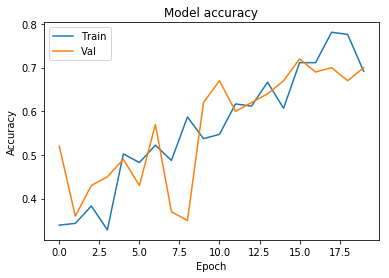

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

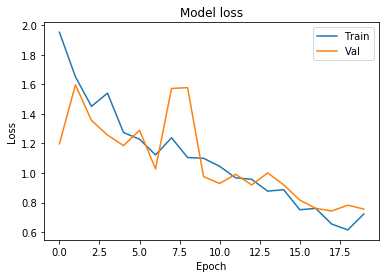

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()